## Triton day2:

Today I am trying to write a kernel which performs matrix additions in 2d.

In [1]:
#lets write a simple 1d array addition on GPU
import triton
import triton.language as tl
import torch

In [2]:
@triton.jit
def matrix_add_kernel(A, B, C, M: tl.constexpr, N: tl.constexpr,
                      BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr):
    pid_m = tl.program_id(0)  # Block ID along the row (M-axis)
    pid_n = tl.program_id(1)  # Block ID along the column (N-axis)

    start_m = pid_m * BLOCK_SIZE_M  # Compute row start index
    start_n = pid_n * BLOCK_SIZE_N  # Compute column start index

    offsets_m = start_m + tl.arange(0, BLOCK_SIZE_M)[:, None]  # Row indices
    offsets_n = start_n + tl.arange(0, BLOCK_SIZE_N)[None, :]  # Column indices

    mask = (offsets_m < M) & (offsets_n < N)  # Ensure we stay within matrix bounds

    # Load matrices
    a = tl.load(A + offsets_m * N + offsets_n, mask=mask)
    b = tl.load(B + offsets_m * N + offsets_n, mask=mask)

    # Perform addition
    c = a + b

    # Store result
    tl.store(C + offsets_m * N + offsets_n, c, mask=mask)

In [3]:
def matrix_add(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    M, N = x.shape  # Get matrix dimensions

    # Define a 2D grid for parallelism
    grid = lambda meta: (
        triton.cdiv(M, meta['BLOCK_SIZE_M']),  # Blocks along rows
        triton.cdiv(N, meta['BLOCK_SIZE_N'])   # Blocks along columns
    )

    # Launch the Triton kernel
    matrix_add_kernel[grid](x, y, output, M, N, BLOCK_SIZE_M=32, BLOCK_SIZE_N=32)
    return output


In [4]:
torch.manual_seed(0)
size = 1024
x = torch.rand((size,size), device='cuda')
y = torch.rand((size,size), device='cuda')
output_torch = x + y
output_triton = matrix_add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([[1.0580, 0.6002, 0.3803,  ..., 0.3048, 1.1496, 1.0413],
        [1.1528, 1.4029, 1.1434,  ..., 0.6426, 0.9942, 0.6621],
        [0.9527, 0.8954, 1.0502,  ..., 0.9767, 0.5670, 0.7493],
        ...,
        [0.9298, 0.8269, 0.8749,  ..., 1.2298, 0.7934, 0.9530],
        [1.7258, 1.0411, 1.0522,  ..., 1.6646, 1.0749, 1.4243],
        [1.5086, 0.1987, 0.6719,  ..., 0.6873, 0.9354, 0.8314]],
       device='cuda:0')
tensor([[1.0580, 0.6002, 0.3803,  ..., 0.3048, 1.1496, 1.0413],
        [1.1528, 1.4029, 1.1434,  ..., 0.6426, 0.9942, 0.6621],
        [0.9527, 0.8954, 1.0502,  ..., 0.9767, 0.5670, 0.7493],
        ...,
        [0.9298, 0.8269, 0.8749,  ..., 1.2298, 0.7934, 0.9530],
        [1.7258, 1.0411, 1.0522,  ..., 1.6646, 1.0749, 1.4243],
        [1.5086, 0.1987, 0.6719,  ..., 0.6873, 0.9354, 0.8314]],
       device='cuda:0')
The maximum difference between torch and triton is 0.0


In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(6, 12)],  # Matrix size: (2^6 x 2^6) → (2^12 x 2^12)
        x_log=True,  # x-axis is logarithmic.
        line_arg='provider',  # Argument name for different providers (Triton, Torch).
        line_vals=['triton', 'torch'],  # Providers to compare.
        line_names=['Triton', 'Torch'],  # Line labels.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Y-axis label (performance metric).
        plot_name='matrix-add-performance',  # Plot filename.
        args={},  # Default arguments for function.
    ))
def benchmark(size, provider):
    x = torch.rand((size, size), device='cuda', dtype=torch.float32)
    y = torch.rand((size, size), device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]

    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    elif provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matrix_add(x, y), quantiles=quantiles)

    # Compute GB/s (Total Memory Accessed / Time)
    bytes_accessed = 3 * x.numel() * x.element_size()  # Read A, Read B, Write C
    gbps = lambda ms: bytes_accessed * 1e-9 / (ms * 1e-3)

    return gbps(ms), gbps(max_ms), gbps(min_ms)


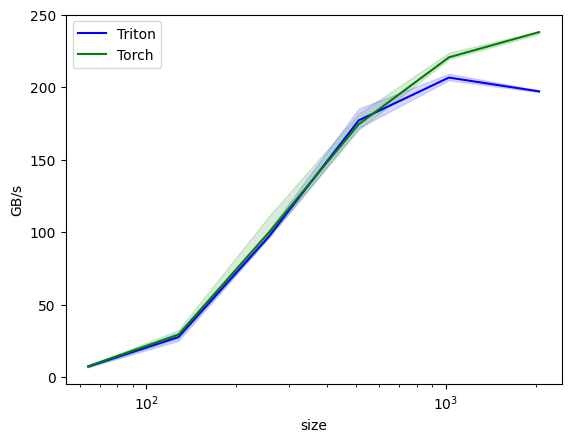

In [10]:
benchmark.run(show_plots=True)